# Домашно 1


### В това домашно задачата е да се класифицират цветовете на автомобили от цветни изображения.

In [1]:
import os
import torch
import numpy as np
import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
import pandas as pd
from PIL import Image
from pprint import pprint
from torchmetrics import Precision, Recall, F1Score
import torchvision.transforms as transforms
from torchvision.models import resnet18, ResNet18_Weights, alexnet, AlexNet_Weights
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import skimage.io as skio


### Нека първо да анализираме данните, които имаме.

In [2]:
path_to_main_directory = './DATA/car-color-image-clasiification/train'

def build_dataframe_from_dir(path_to_main_directory, data_type):
    images = []
    labels = []
    for subdirectory in os.listdir(path_to_main_directory):
        full_path = os.path.join(path_to_main_directory, subdirectory)
        if os.path.isdir(full_path):
            for image in os.listdir(full_path):
                images.append(os.path.join(full_path, image))
                labels.append(subdirectory) 

    df = pd.DataFrame({'label': labels, 'image': images})
    df['data_type'] = data_type
    
    return df

In [3]:
path_to_train_data = './DATA/car-color-image-clasiification/train'
path_to_test_data = './DATA/car-color-image-clasiification/test'
path_to_valid_data = './DATA/car-color-image-clasiification/val'

df_train = build_dataframe_from_dir(path_to_train_data, 'train')
df_test = build_dataframe_from_dir(path_to_test_data, 'test')
df_val = build_dataframe_from_dir(path_to_valid_data, 'val')

train_data_table = df_train.value_counts().reset_index()
print(df_train.value_counts())
print(train_data_table.head())

label   image                                                              data_type
beige   ./DATA/car-color-image-clasiification/train/beige/00ecfeedea.jpg   train        1
purple  ./DATA/car-color-image-clasiification/train/purple/ff2f5ebc0b.jpg  train        1
        ./DATA/car-color-image-clasiification/train/purple/de04aff3cf.jpg  train        1
        ./DATA/car-color-image-clasiification/train/purple/de62a59333.jpg  train        1
        ./DATA/car-color-image-clasiification/train/purple/e0997f98f1.jpg  train        1
                                                                                       ..
green   ./DATA/car-color-image-clasiification/train/green/2453176c3d.jpg   train        1
        ./DATA/car-color-image-clasiification/train/green/267716efd6.jpg   train        1
        ./DATA/car-color-image-clasiification/train/green/269f4cc4a0.jpg   train        1
        ./DATA/car-color-image-clasiification/train/green/28c749ec32.jpg   train        1
yellow  ./DATA/

In [4]:
val_data_table = df_val.value_counts().reset_index()
print(df_val.value_counts())
print(val_data_table.head())

label   image                                                            data_type
beige   ./DATA/car-color-image-clasiification/val/beige/0a8ca5ca17.jpg   val          1
red     ./DATA/car-color-image-clasiification/val/red/1e9f7a6a61.jpg     val          1
purple  ./DATA/car-color-image-clasiification/val/purple/fa0db0fae7.jpg  val          1
        ./DATA/car-color-image-clasiification/val/purple/f4b5de1084.jpg  val          1
        ./DATA/car-color-image-clasiification/val/purple/f4ae263217.jpg  val          1
                                                                                     ..
green   ./DATA/car-color-image-clasiification/val/green/2075052f55.jpg   val          1
        ./DATA/car-color-image-clasiification/val/green/1fbd10babc.jpg   val          1
        ./DATA/car-color-image-clasiification/val/green/1c27ddd6ee.jpg   val          1
        ./DATA/car-color-image-clasiification/val/green/1b36465369.jpg   val          1
yellow  ./DATA/car-color-image-clasii

In [5]:
test_data_table = df_test.value_counts().reset_index()
print(df_test.value_counts())
print(test_data_table.head())

label   image                                                             data_type
beige   ./DATA/car-color-image-clasiification/test/beige/02e37c0e56.jpg   test         1
purple  ./DATA/car-color-image-clasiification/test/purple/ca795b5227.jpg  test         1
        ./DATA/car-color-image-clasiification/test/purple/fa5929e8e3.jpg  test         1
        ./DATA/car-color-image-clasiification/test/purple/f9ec746b81.jpg  test         1
        ./DATA/car-color-image-clasiification/test/purple/f6ce086bf3.jpg  test         1
                                                                                      ..
green   ./DATA/car-color-image-clasiification/test/green/151150bbb1.jpg   test         1
        ./DATA/car-color-image-clasiification/test/green/14b2939176.jpg   test         1
        ./DATA/car-color-image-clasiification/test/green/1385d23c97.jpg   test         1
        ./DATA/car-color-image-clasiification/test/green/0cc0f5ad2d.jpg   test         1
yellow  ./DATA/car-color-i

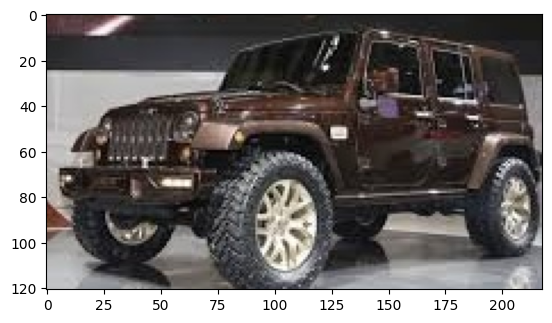

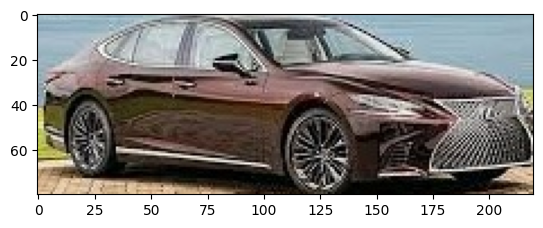

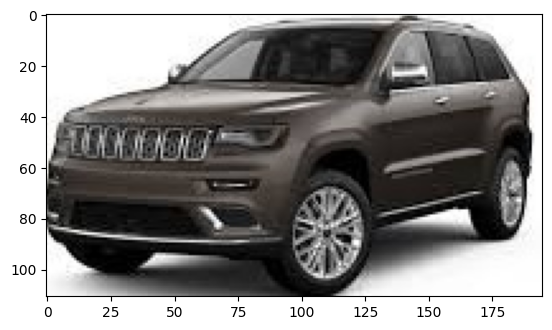

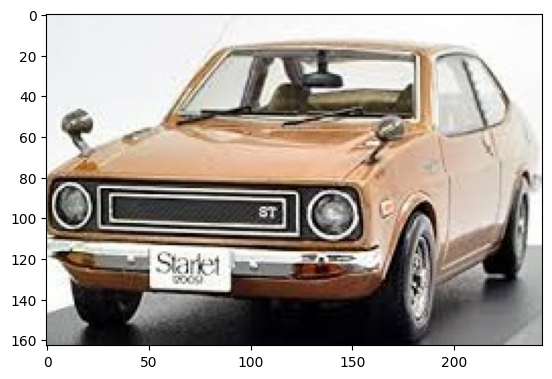

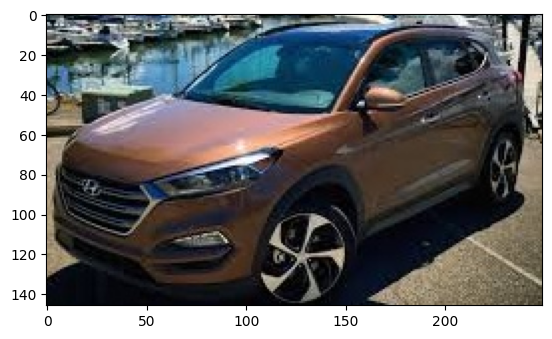

In [6]:
for i in range(5):
    plt.imshow(Image.open(df_train['image'][i]))
    plt.show()

label
blue      371
red       318
yellow    288
brown     282
green     282
purple    268
orange    267
pink      242
grey      214
beige     210
black     203
white     202
tan       200
silver    181
gold      105
Name: count, dtype: int64
Class count is: 15


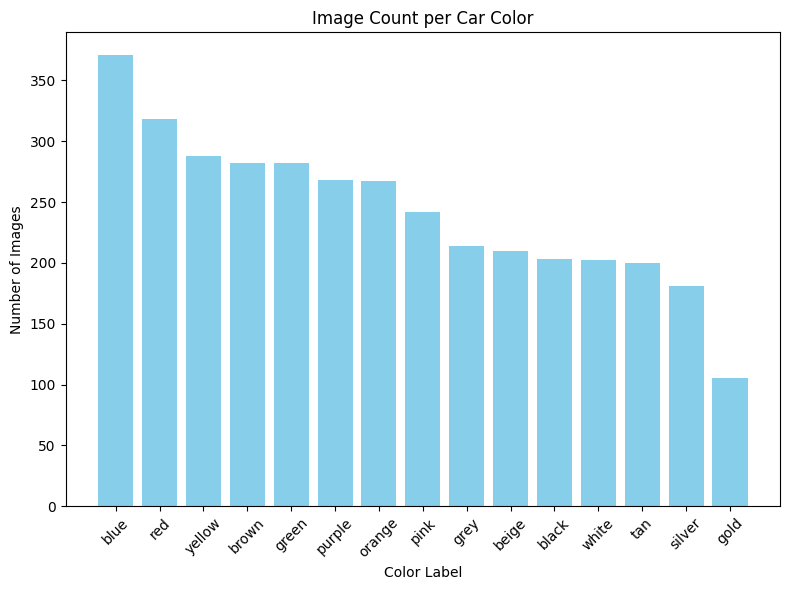

In [7]:
# Create a bar chart to visualize the distribution
label_counts = df_train['label'].value_counts()
print(label_counts)
print(f"Class count is: {len(label_counts)}")

plt.figure(figsize=(8,6))
plt.bar(label_counts.index, label_counts.values, color='skyblue')
plt.xticks(rotation=45)
plt.ylabel("Number of Images")
plt.xlabel("Color Label")
plt.title("Image Count per Car Color")
plt.tight_layout()
plt.show()

In [8]:
sizes = []
resolutions = []

for path in df_train['image']:
    try:
        img = skio.imread(path)

        sizes.append(img.size)
        
        resolution = img.shape[:2]
        resolutions.append(resolution)
    except Exception as e:
        print(f"Could not process image {path}: {e}")

sizes = np.array(sizes)
resolutions = np.array(resolutions)

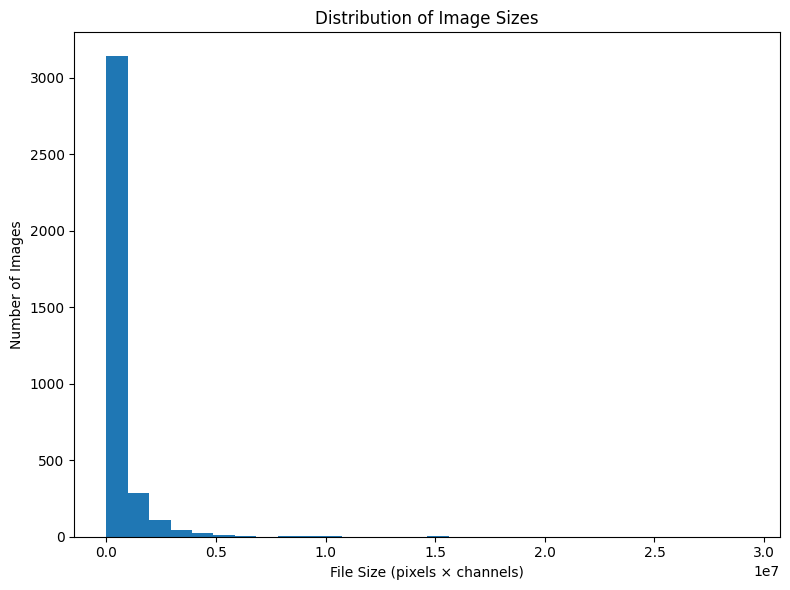

In [9]:
plt.figure(figsize=(8,6))
plt.hist(sizes, bins=30)
plt.title("Distribution of Image Sizes")
plt.xlabel("File Size (pixels × channels)")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

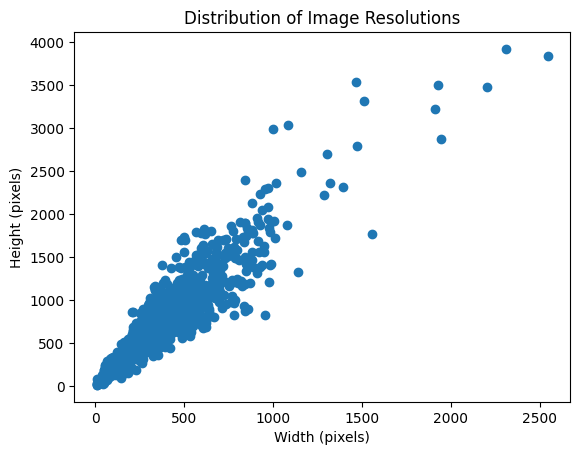

In [10]:
plt.scatter(resolutions[:, 0], resolutions[:, 1])
plt.title("Distribution of Image Resolutions")
plt.xlabel("Width (pixels)")
plt.ylabel("Height (pixels)")
plt.show()

In [11]:
train_transform_demo = transforms.Compose([
    transforms.Resize((128, 128)),  
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10),  
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  
    transforms.ToTensor(),  
    transforms.Normalize([0.5]*3, [0.5]*3) 
])

train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

val_test_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


torch.Size([128, 128, 3])


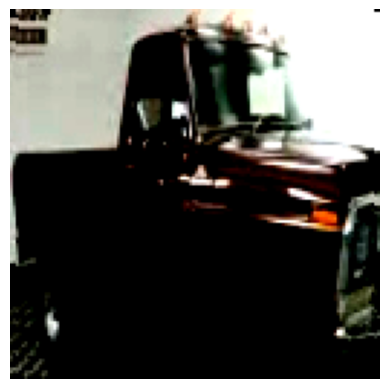

In [12]:
train_dataset_demo = ImageFolder('./DATA/car-color-image-clasiification/train', transform=train_transform_demo)

dataloader_train_demo = DataLoader(
        train_dataset_demo,
        shuffle=True,
        batch_size=16,
    )
image, label = next(iter(dataloader_train_demo))
image = image[0].permute(1, 2, 0)
print(image.shape)

plt.imshow(image)
plt.axis('off')
plt.show()

In [13]:
train_dataset = ImageFolder('./DATA/car-color-image-clasiification/train', transform=train_transform)
test_dataset = ImageFolder('./DATA/car-color-image-clasiification/test', transform=val_test_transform)
val_dataset = ImageFolder('./DATA/car-color-image-clasiification/val', transform=val_test_transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [15]:
class CarColorCNNBase(nn.Module):
    def __init__(self, num_classes=15):
        super(CarColorCNNBase, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),  
            nn.ReLU(),
            nn.MaxPool2d(2, 2),             

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                        

            nn.Flatten(),
            nn.Linear(64 * 32 * 32, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.network(x)
        
class CarColorCNNExp1(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), 
            nn.ReLU(),
            
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(64, 128, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 15)
        )
    def forward(self, x):
        return self.network(x)

class CarColorCNNExp2(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), 
            nn.BatchNorm2d(32), 
            nn.ELU(),
            
            nn.Conv2d(32, 64, 3, padding=1), 
            nn.BatchNorm2d(64), 
            nn.ELU(),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),
            
            nn.Flatten(),
            nn.Linear(64 * 64 * 64, 256),
            nn.ELU(),
            nn.Linear(256, 15)
        )
    def forward(self, x):
        return self.network(x)

class CarColorCNNExp3(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(16, 32, kernel_size=5, padding=2), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(32 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 15)
        )
    def forward(self, x):
        return self.network(x)

class CarColorCNNExp4(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1), 
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten(),
            nn.Linear(64 * 64 * 64, 15)
        )
    def forward(self, x):
        return self.network(x)

class CarColorCNNExp5(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512, 15)
        )

    def forward(self, x):
        return self.network(x)
        
class TransferResNet18(nn.Module):
    def __init__(self, num_classes=15):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.model = resnet18(weights=weights)
        
        for param in self.model.parameters():
            param.requires_grad = False
        
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        return self.model(x)
        
class TransferAlexNet(nn.Module):
    def __init__(self, num_classes=15):
        super().__init__()
        weights = AlexNet_Weights.DEFAULT
        self.model = alexnet(weights=weights)

        for param in self.model.features.parameters():
            param.requires_grad = False

        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, num_classes)
        
    def forward(self, x):
        return self.model(x)

In [16]:
def get_class_distribution(dataset, score_list):
    idx2class = {v: k for k, v in dataset.class_to_idx.items()}
    return {idx2class[i]: score.item() for i, score in enumerate(score_list)}

In [17]:
def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses, val_losses = [], []
    val_f1_scores, val_precision_scores, val_recall_scores = [], [], []
    last_f1_per_class = None

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        train_losses.append(epoch_loss / len(train_loader))

        model.eval()
        val_preds, val_true = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_preds.append(preds)
                val_true.append(labels)

        all_preds = torch.cat(val_preds).cpu()
        all_labels = torch.cat(val_true).cpu()

        f1 = F1Score(task="multiclass", num_classes=15, average='macro')
        f1_score = f1(all_preds, all_labels)

        precision = Precision(task="multiclass", num_classes=15, average='macro')
        precision_score = precision(all_preds, all_labels)

        recall = Recall(task="multiclass", num_classes=15, average='macro')
        recall_score = recall(all_preds, all_labels)

        f1_per_class = F1Score(task="multiclass", num_classes=15, average=None)
        f1_per_class_score = f1_per_class(all_preds, all_labels)
        
        val_f1_scores.append(f1_score.item())
        val_precision_scores.append(precision_score.item())
        val_recall_scores.append(recall_score.item())
        last_f1_per_class = f1_per_class_score.tolist()

    return {
        "Training loss": train_losses,
        "F1": val_f1_scores,
        "Precision": val_precision_scores,
        "Recall": val_recall_scores,
        "F1_per_class": last_f1_per_class,
        "model": model,
    }


In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = {
    "BaseModel": {
        "model": CarColorCNNBase(),
        "description": "2 Conv layers, ReLU, MaxPool, Dropout(0.5)"
    },
    "Model1": {
        "model": CarColorCNNExp1(),
        "description": "3 Conv layers, ReLU, MaxPool"
    },
    "Model2": {
        "model": CarColorCNNExp2(),
        "description": "2 Conv layers, ELU, MaxPool, Dropout(0.3)"
    },
    "Model3": {
        "model": CarColorCNNExp3(),
        "description": "2 Conv layers, ReLU, MaxPool"
    },
    "Model4": {
        "model": CarColorCNNExp4(),
        "description": "1 Conv layer, ReLU, MaxPool"
    },
    "Model5": {
        "model": CarColorCNNExp5(),
        "description": "4 Conv layers, ReLU, MaxPool, BatchNorm, Dropout(0.3)"
    },
    "ResNet": {
        "model": TransferResNet18(),
        "description": "Transfer learning with ResNet18 (frozen features)"
    },
    "AlexNet": {
        "model": TransferAlexNet(),
        "description": "Transfer learning with AlexNet, custom FC layer"
    }
}


results = {}
criterion = nn.CrossEntropyLoss()

for name, entry in models.items():
    print(f"Training {name}")
    model = entry["model"].to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    result = train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, epochs=10)
    results[name] = result

Training BaseModel
Training Model1
Training Model2
Training Model3
Training Model4
Training Model5
Training ResNet
Training AlexNet


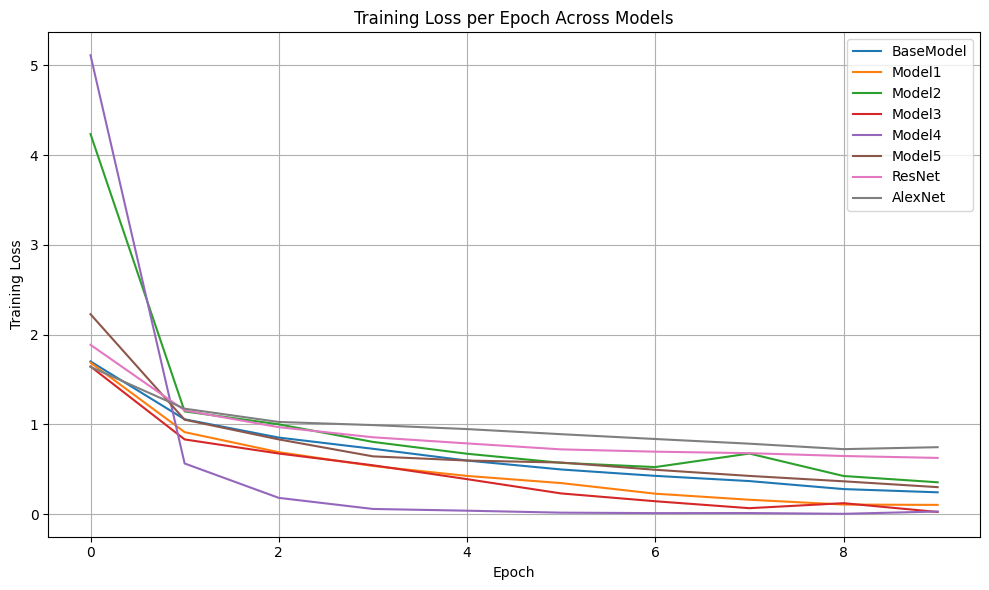

In [19]:
plt.figure(figsize=(10, 6))
for name, result in results.items():
    plt.plot(result["Training loss"], label=name)

plt.title("Training Loss per Epoch Across Models")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


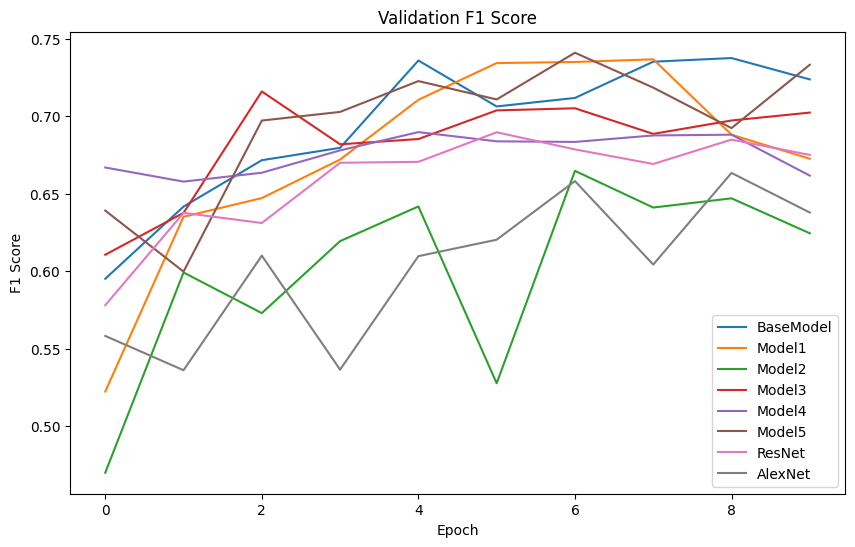

,Model,Description,Avg F1,Final F1,Avg Precision,Final Precision,Avg Recall,Final Recall,Avg F1 per class,Final F1 per class
0,BaseModel,"2 Conv layers, ReLU, MaxPool, Dropout(0.5)",0.693883,0.723792,0.722004,0.747594,0.704473,0.725901,0.723792,0.869888
1,Model1,"3 Conv layers, ReLU, MaxPool",0.675420,0.672602,0.712363,0.710363,0.688090,0.680695,0.672602,0.851852
2,Model2,"2 Conv layers, ELU, MaxPool, Dropout(0.3)",0.600850,0.624497,0.637304,0.658497,0.608860,0.631768,0.624497,0.798206
3,Model3,"2 Conv layers, ReLU, MaxPool",0.682874,0.702371,0.704901,0.710594,0.689662,0.702594,0.702371,0.876494
4,Model4,"1 Conv layer, ReLU, MaxPool",0.676077,0.661683,0.696421,0.684135,0.675720,0.664808,0.661683,0.891667
5,Model5,"4 Conv layers, ReLU, MaxPool, BatchNorm, Dropout(0.3)",0.695755,0.733245,0.725299,0.759031,0.700381,0.732190,0.733245,0.916335
6,ResNet,Transfer learning with ResNet18 (frozen features),0.658488,0.675063,0.679111,0.684711,0.660809,0.677467,0.675063,0.913386
7,AlexNet,"Transfer learning with AlexNet, custom FC layer",0.603480,0.637875,0.661331,0.672816,0.614145,0.641043,0.637875,0.886275


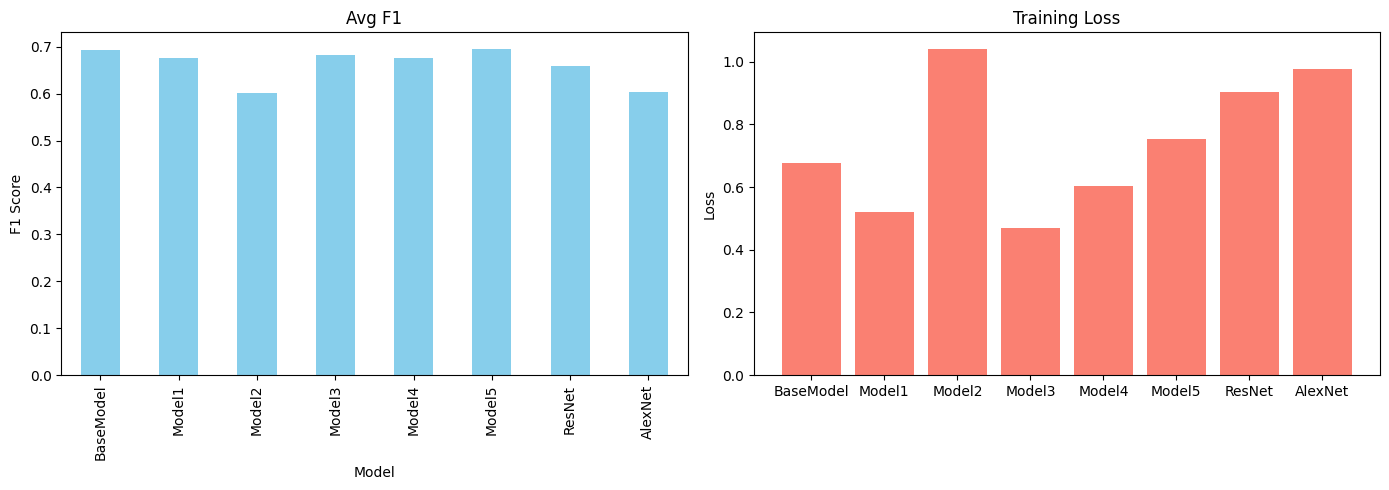

In [20]:
plt.figure(figsize=(10,6))
for name, result in results.items():
    plt.plot(result["F1"], label=name)
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.legend()
plt.show()

summary_data = []
for name, result in results.items():
    summary_data.append({
        "Model": name,
        "Description": models[name]["description"] if isinstance(models[name], dict) else "N/A",
        "Avg F1": np.mean(result["F1"]),
        "Final F1": result["F1"][-1],
        "Avg Precision": np.mean(result["Precision"]),
        "Final Precision": result["Precision"][-1],
        "Avg Recall": np.mean(result["Recall"]),
        "Final Recall": result["Recall"][-1],
        "Avg F1 per class": np.mean(result["F1_per_class"]),
        "Final F1 per class": result["F1_per_class"][-1]
    })

df_summary = pd.DataFrame(summary_data)

df_summary.to_csv("model_experiment_summary.csv", index=False)

best_f1 = df_summary["Avg F1 per class"].max()
def highlight_best(s):
    return ['background-color: lightgreen' if v == best_f1 else '' for v in s]

styled_df = df_summary.style.apply(highlight_best, subset=["Avg F1 per class"])
display(styled_df)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

df_summary.plot(x="Model", y="Avg F1", kind="bar", ax=axes[0], color="skyblue", legend=False)
axes[0].set_title("Avg F1")
axes[0].set_ylabel("F1 Score")


final_losses = [np.mean(results[row["Model"]]["Training loss"]) for _, row in df_summary.iterrows()]

axes[1].bar(df_summary["Model"], final_losses, color="salmon")
axes[1].set_title("Training Loss")
axes[1].set_ylabel("Loss")

plt.tight_layout()
plt.show()

In [21]:
best_model_name = max(results.items(), key=lambda x: max(x[1]['F1']))[0]
model = models[best_model_name]["model"]
print(f"Best model is: {best_model_name}")

test_running_loss = 0.0
model.eval()
correct = 0
total = 0
test_preds, test_true = [], []
test_losses = []
val_f1_scores = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        test_running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        test_preds.append(preds)
        test_true.append(labels)

avg_test_loss = test_running_loss / len(test_loader)
test_losses.append(avg_test_loss)

f1_global = F1Score(task="multiclass", num_classes=len(label_counts), average='micro')
f1_score_test = f1_global(torch.cat(test_preds), torch.cat(test_true))

val_f1_scores.append(f1_score_test.item())

print(f"Average test loss {avg_test_loss: 6f}")
print(f"Test metric score {f1_score_test.item(): 6f}")

Best model is: Model5
Average test loss  1.018637
Test metric score  0.782776


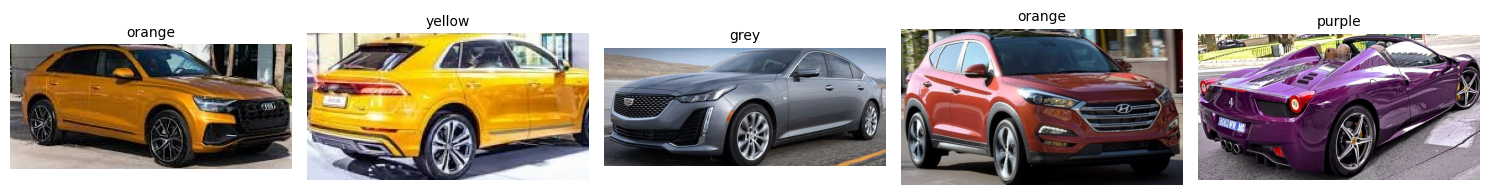

In [27]:
idx_to_class = {v: k for k, v in val_dataset.class_to_idx.items()}
test_dir = './DATA/car-color-image-clasiification/test'

all_image_paths = []
for root, dirs, files in os.walk(test_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            all_image_paths.append(os.path.join(root, file))

random_image_paths = random.sample(all_image_paths, 5)

model.eval()

plt.figure(figsize=(15, 6))

for idx, img_path in enumerate(random_image_paths):
    image_raw = Image.open(img_path).convert('RGB')
    input_tensor = val_test_transform(image_raw).unsqueeze(0) 

    with torch.no_grad():
        output = model(input_tensor)
        _, pred = torch.max(output, 1)
        predicted_label = idx_to_class[pred.item()]

    plt.subplot(1, 5, idx + 1)
    plt.imshow(image_raw)
    plt.title(predicted_label, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()

